
## Thresholding:
Thresholding is a type of image segmentation where we change the value of pixels based on a criteria (threshold) for analysis purposes.  A threshold in image processing could be likened to height sticks used in amusement parks. Any child shorter than the stick is denied, whereas the rest is allowed to enjoy the ride. Likewise, each pixel's value is compared to a pre-determined threshold, and based on that each pixel value is changed. We use this method to select objects of interest, while ignoring the rest.

(-0.5, 1299.5, 1299.5, -0.5)

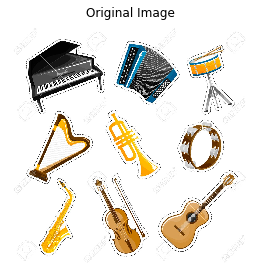

In [1]:
#Import necessary libraries
import skimage.io
import matplotlib.pyplot as plt
from skimage.filters import gaussian
import numpy as np
musical = skimage.io.imread('musical_instruments.jpg')
skimage.io.imshow(musical)
plt.title('Original Image')
plt.axis('off')

Here, we are interested in the musical instruments only. So, we will turn on the pixels belonging to the musical instruments, while turning off  the rest of the image pixels.

First, we will convert the image to grayscale, and apply a Gaussian filter and thresholding. The pixels less than the threshold value would be turned off. Since we do not want to omit any valuable data, we need to come up with a good threshold value. For that, we would have to look at the histogram of the grayscale image.  

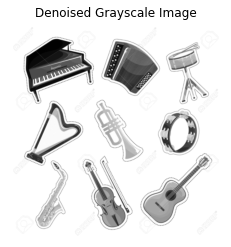

In [2]:
#Convert image to grayscale
gray_musical = skimage.color.rgb2gray(musical)
#Denoise the image
blurred_musical = skimage.filters.gaussian(gray_musical, sigma=1.0)
#Plot the result
plt.imshow(blurred_musical, cmap='gray')
plt.axis('off')
plt.title('Denoised Grayscale Image')
plt.show()

Let's plot the histogram of the grayscale image by using numpy's histogram() function:

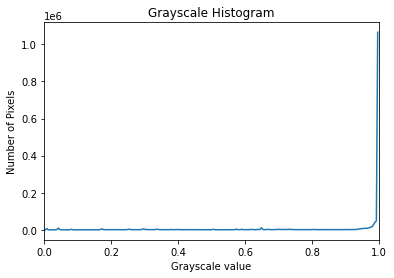

In [3]:
#Create and plot the histogram:
histogram, bin_edges = np.histogram(blurred_musical, bins=256, range=(0.0, 1.0))
plt.plot(bin_edges[0:-1], histogram)
plt.title('Grayscale Histogram')
plt.xlabel('Grayscale value')
plt.ylabel('Number of Pixels')
plt.xlim([0, 1.0])
plt.show()

Since the background of the image is white, we see a peak at 1. We see some waves before the peak, but they are barely visible. Let's ignore the peak so we could zoom in on those peaks:  

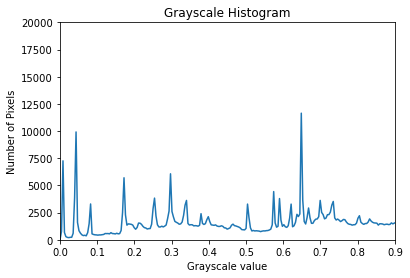

In [4]:
#Draw the histogram without the peak at 1
plt.plot(bin_edges[0:-1], histogram)
plt.title('Grayscale Histogram')
plt.xlabel('Grayscale value')
plt.ylabel('Number of Pixels')
plt.xlim([0, 0.9])
plt.ylim([0,20000])
plt.show()

Now, we see lots of important data that we do not want to miss out on. But after 0.85, the graph flat-lines a bit before peaking at 1. So, it seems like if we choose our threshold around the value of 0.85, we will not miss any musical instruments' pixels but will turn off the white background.  Let's create a binary mask that will black out anything with a value greater than 0.85. 

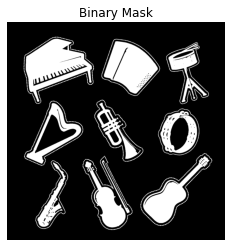

In [5]:
#Create a binary mask with threshold value of 0.85
threshold = 0.85
mask = blurred_musical < threshold
plt.imshow(mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')
plt.show()

We created a black and white (binary) mask for the image. Let's apply that mask to the image to bring only the musical instruments to the foreground and black out the rest of the image.

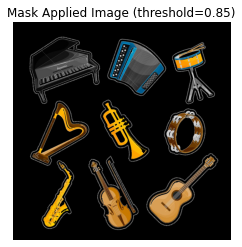

In [6]:
#Create a mask with all zero values
selection = np.zeros_like(musical)
#Change mask's pixel values to show through the colors of the instruments
selection[mask] = musical[mask]
#Plot the mask 
plt.imshow(selection)
plt.title('Mask Applied Image (threshold=0.85)')
plt.axis('off')
plt.show()

So far, we practiced detecting an appropriate threshold value by inspecting the histogram. 

We can also let skimage find the best threshold automatically.

In the following section, we will find the threshold by using **Otsu's method**. Then, we will use **try_all_threshold()** function which goes through many different thresholding algorithms to produce thresholds. Based on these results we can decide which algorithm works best for the task at hand.

**The Otsu's Method:**

In [7]:
#Find Otsu threshold:
threshold_otsu = skimage.filters.threshold_otsu(blurred_musical) 
print('Threshold found with Otsu\'s method is : {}'.format(round(threshold_otsu, 3)))

Threshold found with Otsu's method is : 0.667


Now we will create a binary mask by using this threshold value:

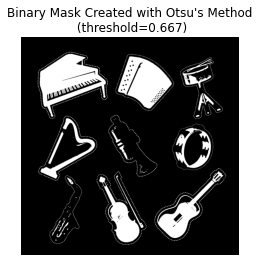

In [8]:
#Creating a binary mask:
mask_otsu = blurred_musical < threshold_otsu
#Plotting the binary mask
plt.imshow(mask_otsu, cmap='gray')
plt.title('Binary Mask Created with Otsu\'s Method\n (threshold=0.667)')
plt.axis('off')
plt.show()

Let's apply that binary mask to the original image to bring the musical instruments to the foreground.

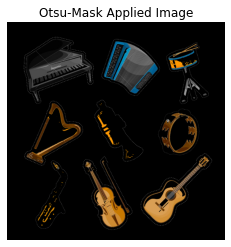

In [9]:
#Create a mask with all zero values
selection_otsu = np.zeros_like(musical)
#Change mask's pixel values to show through the colors of the instruments
selection_otsu[mask_otsu] = musical[mask_otsu]
#Plot the mask
plt.imshow(selection_otsu)
plt.title('Otsu-Mask Applied Image')
plt.axis('off')
plt.show()

Let's compare the result of Otsu's method with the one we obtained by selecting a threshold:

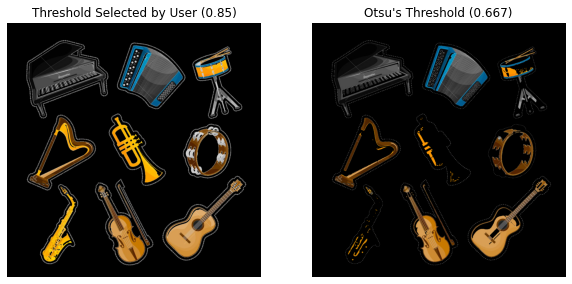

In [10]:
fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(10,8))
ax[0].imshow(selection)
ax[0].set_title('Threshold Selected by User (0.85)')
ax[1].imshow(selection_otsu)
ax[1].set_title('Otsu\'s Threshold (0.667)')
for a in ax:
    a.axis('off')

With Otsu's method we were able to get rid of the outline around the musical instruments at the expense of losing valuable details of the musical instruments. Let's say our goal is to count the number of the musical instruments, then Otsu's method provides enough data at a lot less computational expense. However, if our goal involves having as much details of the objects as possible, then user defined threshold is the option to go with.    

**"Try All" method:**

Let's use try_all_threshold() function from skimage.filters to detect threshold values calculated by seven different algorithms. 

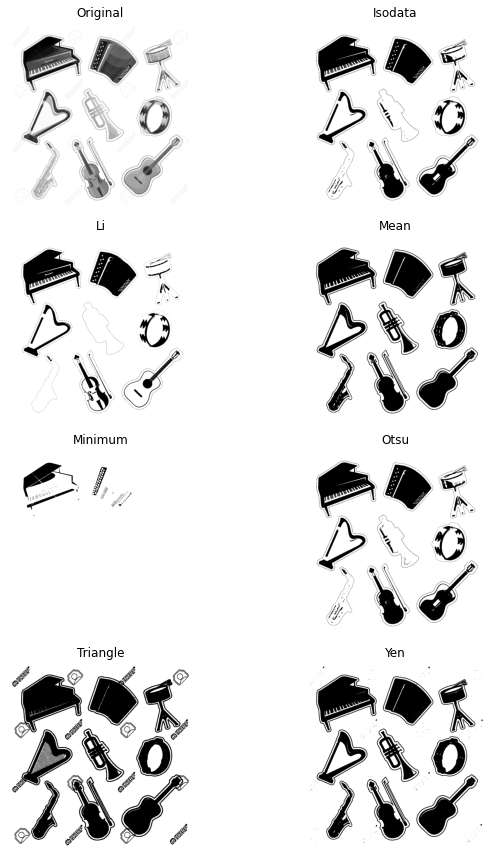

In [11]:
#import necessary function:
from skimage.filters import try_all_threshold
#Plot all thresholded, masked images.
fig, ax = try_all_threshold(blurred_musical, figsize=(14, 12), verbose=False)
plt.tight_layout()
plt.show()

Let's write a function that will go through those thresholding algorithms, create a mask with the newly created threshold and apply it to the original image.

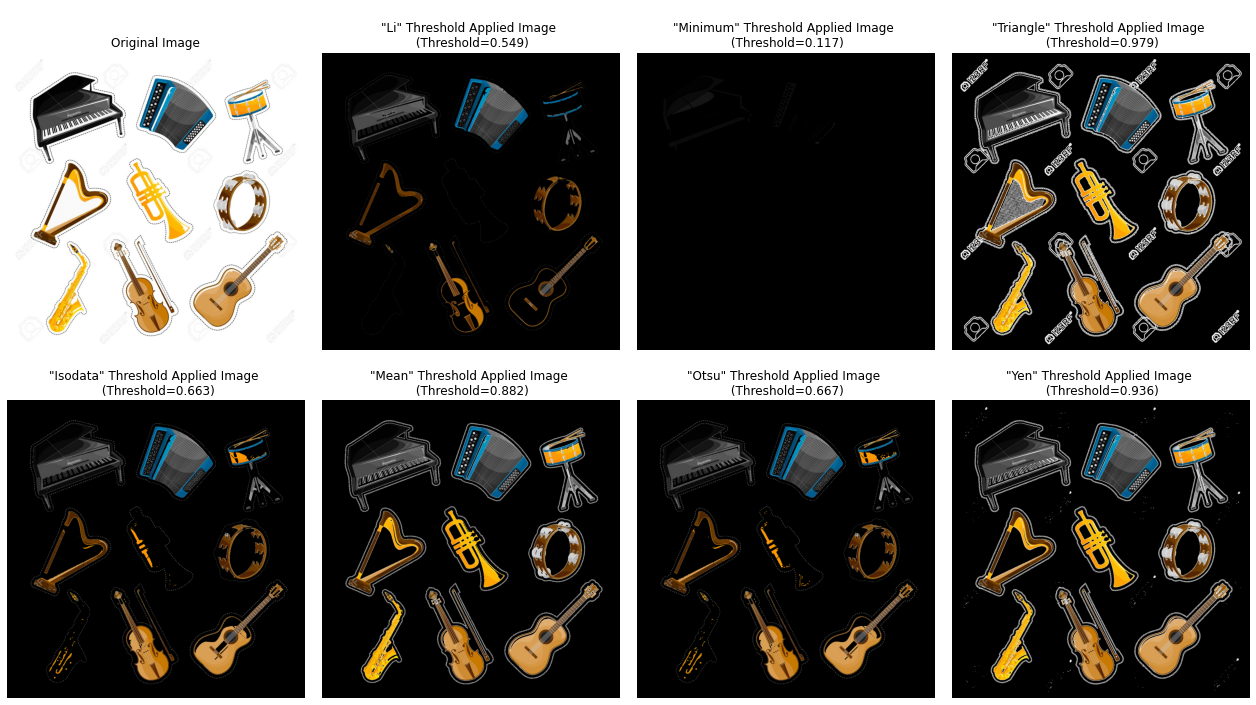

In [12]:
#Import necessary thresholding functions: 
from skimage.filters import (threshold_li, threshold_minimum,
                                          threshold_triangle, threshold_isodata,
                                          threshold_mean, threshold_otsu, threshold_yen)
def apply_thresh_algorithm(image):
    '''
        This function takes in an image, turns it to grayscale, 
        denoises it with a Gaussian filter. 
        It then calculates seven threshold values 
        corresponding to seven different algorithms for this
        grayscale image, creates masks using those values 
        and finally applies those masks to the original image.
        All masked images are plotted along with the original image 
        for comparison purposes. 
    '''
    grayscale_image = skimage.color.rgb2gray(image)
    blurred_image = skimage.filters.gaussian(grayscale_image)
    thresh = [threshold_li, threshold_minimum, threshold_triangle, 
              threshold_isodata, threshold_mean, threshold_otsu, threshold_yen]
    algorithm_name = []
    #Plot the Original and masked images:
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 10), sharex=True, sharey=True)
    ax =ax.ravel()
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    count = 0
    for i in thresh:
        count += 1
        algorithm_name.append((str(i).split('_')[1]).split(' ')[0].title())
        thresh = i(blurred_image)
        mask = blurred_image < thresh
        selection = np.zeros_like(image)
        selection[mask] = image[mask]
        ax[count].imshow(selection)
        ax[count].set_title('\n\"{}\" Threshold Applied Image \n (Threshold={})'.format(algorithm_name[-1], round(thresh,3)))
    plt.tight_layout()
    for a in ax:
        a.axis('off')
apply_thresh_algorithm(musical)


When we look at the masked images above, we see that "Minimum" algorithm produces an image with barely visible objects with a threshold of 0.117 and "Triangle" algorithm lets almost every tiny detail to pass through with a threshold value of 0.979. As mentioned above, we should pick an appropriate method depending on the requirements of our task.  

## Exercise: Measuring Bacterial Growth in Several Petri Dishes

Now, we will take a look at how we can utilize thresholding and masking to determine the ratio of the bacterial growth in several petri dishes. 
I found <a href="https://www.researchgate.net/figure/Growth-of-bacterial-colony-on-TSA-plates-inoculated-with-different-natural-bamboo-fiber_fig3_343919609"> this </a> research paper that inspects how bacterial growth takes place in several petri dishes inoculated with different kinds of bamboo fibers. 

Specifically; "Growth of bacterial colony on TSA plates inoculated with different natural bamboo fiber (NBF) samples [KP ¼ K. pneumoniae; SA ¼ S. aureus; B-25, M-25, and R-9 are NBFs from Bissetii, Moso, and Red Margin bamboo species respectively]."

(-0.5, 849.5, 453.5, -0.5)

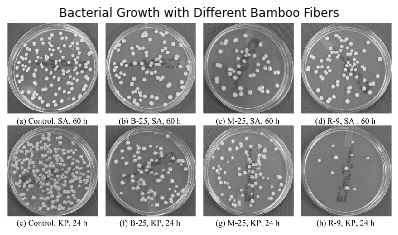

In [13]:
#Load the image as grayscale
bacterial_growth=skimage.io.imread('bacterial_growth.png', as_gray=True)
skimage.io.imshow(bacterial_growth)
plt.title('Bacterial Growth with Different Bamboo Fibers')
plt.axis('off')

We will disect the image into 8 little images (img_1, img_2, ..img_8) for each petri dish. To keep things simple, we will print out the bacterial growth ratio for img_1, img_2,..img_8, rather than labeling them by bamboo species.  

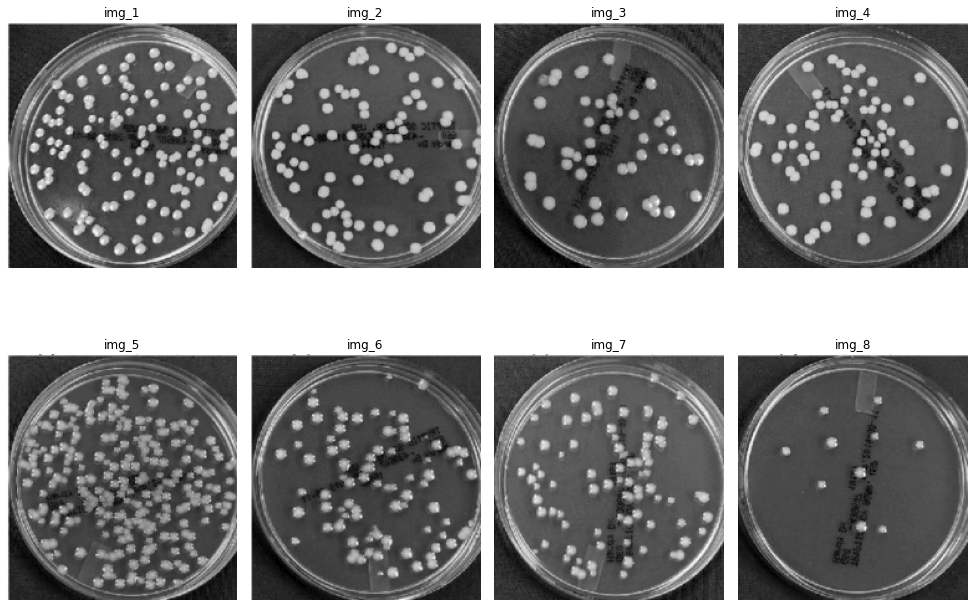

In [14]:
#Create a list that will hold strings "img_1", "img_2",.."img_8".
#Create variables whose names will be same as the strings.
#Each petri dish image will be assigned to the newly created variable.
images = []
for i in range(8):
    images.append("img_{}".format(i+1))

for i in range(4):
    locals()[images[i]] = bacterial_growth[:200, 217*i:200+212*i]
for i in range(4):
    locals()[images[i+4]] = bacterial_growth[227:425,217*i:200+212*i]
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 10), sharex=True, sharey=True)
ax = ax.ravel()

for i in range(8):
    ax[i].set_title('img_{}'.format(i+1))
    ax[i].imshow(locals()[images[i]], cmap=plt.cm.gray)
plt.tight_layout()
for a in ax:
    a.axis('off')

To find the bacterial growth, we need to focus on the little dots in each petri dish. We will turn them "on", and turn off the rest of the image. Unfortunately, we can not achieve this simply by applying a threshold, since the petri dish perimeter shows up on the images and its grayscale value is too close to the little dots' values. Applying a threshold to get rid of it would mean getting rid of crucial bacterial growth information as well. So, it may be a good idea to apply a circular mask to each image to get rid of the perimeter of the petri dishes. This, unfortunately will not render the perfect image with only the bacterial growth data we are seeking. The reason for that is the petri dishes are not perfect circles. Still, we will do our best to remove the petri dish pixels as much as possible.

The following function applies a circular mask to a given image.

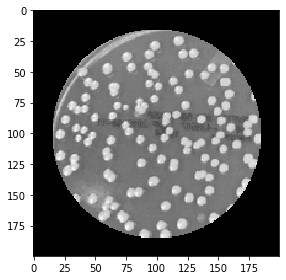

In [15]:
def circular_mask(image):
    '''
        This function applies a circular mask to the input image.'''
    rr,cc = skimage.draw.disk((100,100), 85)
    binary_mask = np.ones(shape=image.shape[:2], dtype=bool)
    binary_mask[rr, cc]=False
    image_masked = image.copy()
    image_masked[binary_mask]=0
    return image_masked
skimage.io.imshow(circular_mask(img_1))

Let's create a function that applies a Gaussian filter with sigma value of 1 and a threshold of 0.6 to a given image. 

In [16]:
#This function applies a Gaussian filter to denoise it.
#A mask with threshold of 0.6 is applied.
#Masked version of the given image is returned
def apply_Gaussian_thresh(image):
        '''
            This function takes in an image, denoises it with a gaussian
            function, creates a mask with  a threshold value of 0.6, returns
            an image with objects whose values are greater than the threshold.'''
        blurred_image = skimage.filters.gaussian(image, sigma=1.0) 
        threshold=0.6
        binary_mask = blurred_image > threshold
        selection = np.zeros_like(image)
        selection[binary_mask] = image[binary_mask]
        return selection

Now that we created the two functions we needed to mask, denoise and threshold, we can apply them to each of the eight images. 

(-0.5, 199.5, 199.5, -0.5)

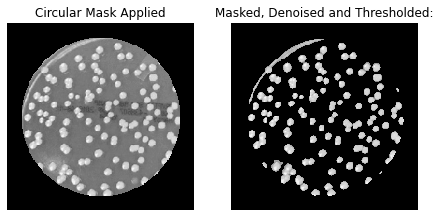

In [17]:
#The following code applies circular mask to each of the eight images.
#Then the resulting images are denoised by a Gaussian filter and a threshold 
#(0.6) is applied to every one of them

#masked_images holds circular-mask applied images
masked_images = []
for i in range(8):
    masked_images.append(circular_mask(locals()[images[i]]))
plt.subplot(1,2,1)
skimage.io.imshow(masked_images[0])
plt.title('Circular Mask Applied')
plt.axis('off')

#denoised_threshold holds denoised, thresholded images
denoised_threshold = []
for i in range(8):
    denoised_threshold.append(apply_Gaussian_thresh(masked_images[i]))
plt.subplot(1,2,2)
skimage.io.imshow(denoised_threshold[0])
plt.title('Masked, Denoised and Thresholded:')
plt.axis('off')


The following code lays out the original images and the end results together for comparison purposes. 

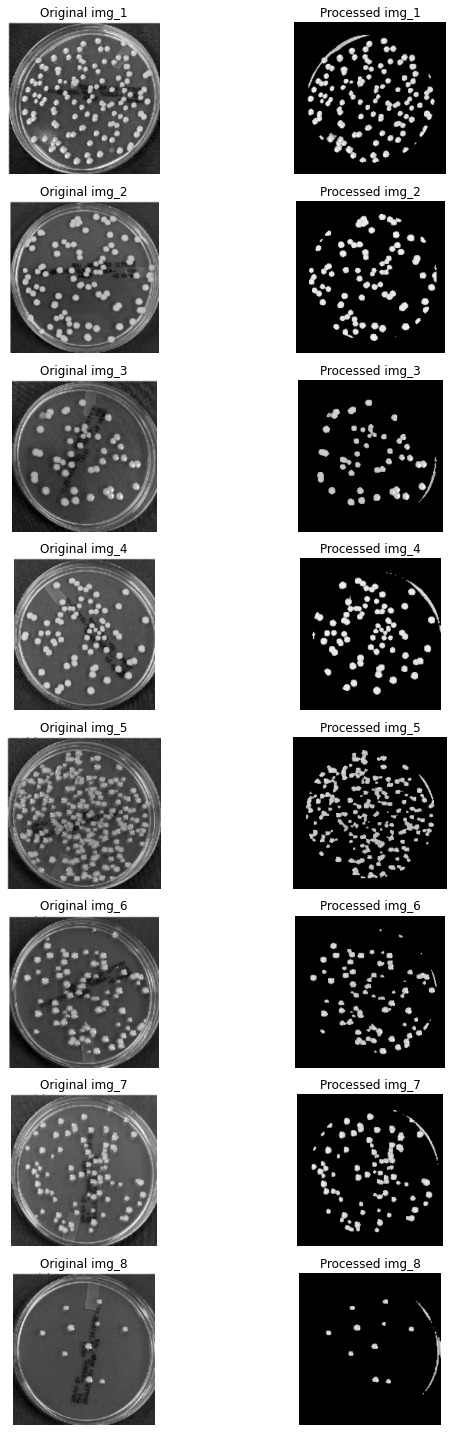

In [18]:
%matplotlib inline
fig, ax = plt.subplots(8,2, figsize=(10,20))

for i in range(8):
    j=0
    ax[i, j].set_title('Original '+images[i])
    ax[i, j].imshow(locals()[images[i]], cmap=plt.cm.gray)
    ax[i, j].axis('off')
    ax[i, j+1].set_title('Processed ' + images[i])
    ax[i, j+1].imshow(denoised_threshold[i], cmap=plt.cm.gray)
    ax[i, j+1].axis('off')
plt.tight_layout()    


Finally, we are ready to find the ratio of the bacterial growth for each image. To do this, we will count all non-zero value pixels and divide it by the total number of pixels of the image.
The following function implements this:

In [19]:
def find_ratio(image):
    '''
    This function takes in an image, finds how many pixels 
    the image consists of, and counts how many of those pixels 
    have non-zero values. Finally returns the ratio of nonzero pixel
    count to the total pixel count.
    '''
    #find total number of pixels of the image
    total_pixels = image.shape[0] *image.shape[1]
    #count non zero pixels.
    non_zero_pixels = np.count_nonzero(image)
    # return the ratio of non-zero count to total count
    return non_zero_pixels/total_pixels

In [20]:
#Create a dictionary to hold each image name and the corresponding ratio
image_ratio = {}
for i in range(8):
    image_ratio[images[i]] = np.round(find_ratio(denoised_threshold[i]),3)
image_ratio

{'img_1': 0.137,
 'img_2': 0.104,
 'img_3': 0.068,
 'img_4': 0.111,
 'img_5': 0.138,
 'img_6': 0.077,
 'img_7': 0.093,
 'img_8': 0.02}

In [21]:
import pandas as pd
#Display bacterial growth ratios as a DataFrame:
dict_for_dataframe = {}
dict_for_dataframe['Image Name'] = images
dict_for_dataframe['Growth Ratio'] = list(image_ratio.values())
df = pd.DataFrame(dict_for_dataframe)
df['Growth Ratio'] = df['Growth Ratio'].astype('str')
df.style.hide_index()

Image Name,Growth Ratio
img_1,0.137
img_2,0.104
img_3,0.068
img_4,0.111
img_5,0.138
img_6,0.077
img_7,0.093
img_8,0.02


So, we see that img_5 has the highest growth, followed by img_1. The least amount of growth is observed in the last image. These findings are consistent with what we can infer by inspecting the images visually.